*Question 1:* Generate a data set with $p = 20$ features, $n = 1000$ observations, and an associated quantitative response vector generated according to the model $Y = X\beta + \epsilon$, where $\beta$ has some elements that are exactly equal to zero. Split your data set into a training data set containing $100$ observations and a test set containing $900$ observations.

1. Perform best subset selection on training set and plot the training set MSE associated with the best model of each size.
1. plot AIC (or Cp) for the best model of each size.
1. Plot the test MSE associated with the best model of each size. For which model size does the test MSE takes on its minimum value?
1. Compare your results to the true model used to generate the data.


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(0)

num_features = 20 #p
num_observations = 1000 #n

data = np.random.rand(num_observations, num_features)
beta = np.random.randint(0, 9,size=num_features)
#print(beta) confirms that beta has some zero elements for random seed 0.

response = data.dot(beta) #Y

X_train, X_test, y_train, y_test = train_test_split(data, response, test_size=0.9, random_state=0)

print(beta)

[5 0 3 0 0 4 8 5 1 4 8 7 6 6 3 1 6 3 1 7]


Best subset by score: (0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)
Best cross-validation score: -1.072850831100576e-28


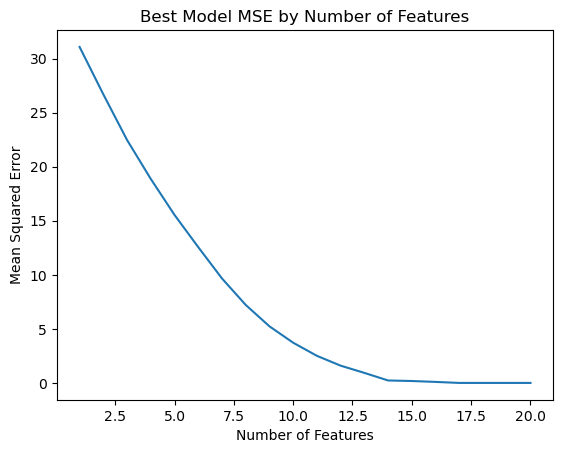

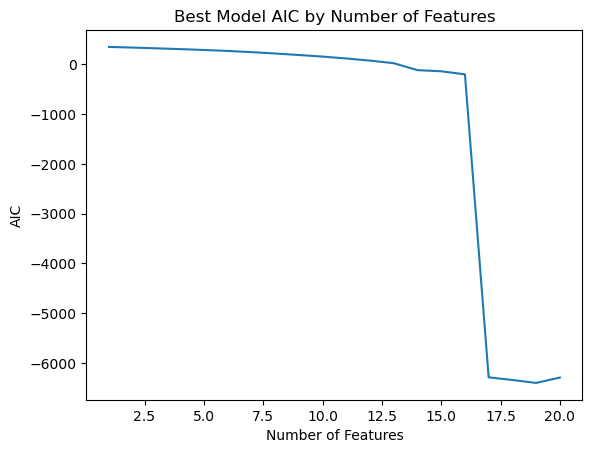

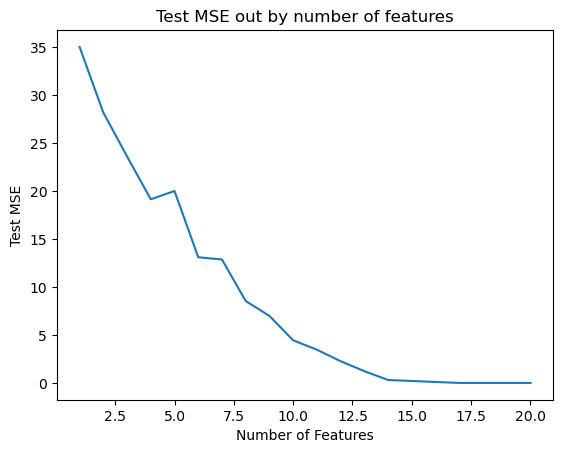

In [2]:
#1.1 Perform best subset selection on training set and plot the training set mean squared error associated with the best model of each size
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Initialize the linear regression model
model = LinearRegression()

# Function to get the best subset
def get_best_subset(X_train, y_train, X_test, y_test, model, max_features=None):
    n_features = X_train.shape[1]
    n_observations = X_train.shape[0]
    if max_features is None:
        max_features = n_features
    
    absolute_best_score = -np.inf
    absolute_best_subset = None
    test_mse_vector = np.full(max_features+1, np.inf)

    relative_best_mean_squared_error_plot = np.full(max_features+1, np.inf)
    relative_features_count = np.arange(0, max_features+1)
    AIC_vector = np.zeros(max_features+1)

    # Iterate over all possible combinations of features
    for L in relative_features_count:
        relative_best_score = -np.inf
        relative_best_subset = None
        for subset in itertools.combinations(range(n_features), L):
            if L == 0:
                AIC_vector[L] = np.inf
                continue
            X_train_subset = X_train[:, subset]
            X_test_subset = X_test[:, subset]
            score = cross_val_score(model, X_train_subset, y_train, cv=5, scoring='neg_mean_squared_error').mean()  # Change cv for different cross-validation strategies
            SSE = - n_observations * score
            if score > relative_best_score:
                relative_best_score = score
                relative_best_subset = subset
                AIC_vector[L] = n_observations * np.log(SSE / n_observations) + 2 * (L + 1)
            if score > absolute_best_score:
                absolute_best_score = score
                absolute_best_subset = subset
        if relative_best_subset is not None:
            relative_best_mean_squared_error_plot[L] = relative_best_score
            model.fit(X_train[:, list(relative_best_subset)], y_train)
            y_pred = model.predict(X_test[:, list(relative_best_subset)])
            test_mse_vector[L] = mean_squared_error(y_test, y_pred)
        else:
            relative_best_mean_squared_error_plot[L] = np.inf
            test_mse_vector[L] = np.inf
    return absolute_best_subset, absolute_best_score, - relative_best_mean_squared_error_plot, relative_features_count, AIC_vector, test_mse_vector

# Find the best subset of features
best_subset, best_score, MSE_out, features_index, AIC_out, test_mse_out = get_best_subset(X_train, y_train, X_test, y_test, model)
print("Best subset by score:", best_subset)
print("Best cross-validation score:", best_score)

plt.plot(features_index, MSE_out)
plt.title('Best Model MSE by Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.show()

plt.plot(features_index, AIC_out)
plt.title('Best Model AIC by Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('AIC')
plt.show()

plt.plot(features_index, test_mse_out)
plt.title('Test MSE out by number of features')
plt.xlabel('Number of Features')
plt.ylabel('Test MSE')
plt.show()


The MSE takes its minimum value at 15-20 features. Overall, more features appears to make a more accurate model. This lines up with the true model, for which the linear $\beta$ relationships were determined as random positive integers with three zeros. The best models involve eliminating those three irrelevant features with zero relation, so best subset selection optimizes at slightly lower than 20 features, starting to minimize at around 15. This trend lines up with the absolutely unimpactful 3 $\beta_i=0$ parameters, and the relatively unimpactful 3 $\beta_i = 1$ parameters. 

*Question 2:* Suppose that we have $n$ distinguishable samples and that we perform a bootstrap sampling once. Mathematically show that the expected value of the fraction of unique samples is roughly $2/3$. Simulate this process in `Python` and verify your answer.

1. The probability that a sample is picked is $\frac{1}{n}$.

1. The probability that a sample is *not* picked is $1 - \frac{1}{n}$.

1. The probability that it is not picked at all in $n$ draws is $(1 - \frac{1}{n})^n$. 

1. The limit of the probability that the sample is not picked at all as the number of trials approaches infinity is $ p(\mathrm{not picked at all}) = \mathrm{lim}_{n \rightarrow \infty} (1 - \frac{1}{n})^n = \frac{1}{e}$

1. $p(\mathrm{picked}) = 1 - p(\mathrm{not picked at all}) = 1 - \frac{1}{e} = 0.6321 \approx \frac{2}{3}$

1. $\frac{E[\mathrm{unique samples}]}{n} \approx \frac{2}{3}$ Q.E.D.

In [3]:
n = 1000000
samples = np.arange(1, n)#the sample space
collection = np.zeros(n) #the bin of collection samples
n_picked = np.zeros(n) #how much times was the corresponding sample from the sample space picked?

for sample in range(0, n):
  collection[int(sample)] = np.random.randint(1, n)
  n_picked[int(collection[int(sample)])] = n_picked[int(collection[int(sample)])] + 1

print(n_picked)

uniques = 0
for sample in range(0, n):
  if n_picked[sample] > 0:
    uniques = uniques + 1   

print(f'Expected uniques rate: {uniques / n}')
print(f'Theoretical value: {1 - (1 - 1 / n)**n}')

[0. 2. 1. ... 2. 2. 2.]
Expected uniques rate: 0.63261
Theoretical value: 0.6321207427789335
